# Initialization

In [1]:
!pip install -qU transformers datasets evaluate accelerate peft huggingface_hub peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import numpy as np
import json
import librosa
from IPython.display import Audio as AudioDisplay
import pandas as pd
import soundfile as sf
import random
import time
import tqdm
from sklearn.metrics import accuracy_score

from transformers import HubertModel, HubertConfig, PretrainedConfig, PreTrainedModel, TrainingArguments, Trainer
from transformers import AutoModel, AutoFeatureExtractor, AutoModelForAudioClassification, AutoProcessor
from datasets import load_dataset, Audio, Dataset
import evaluate
from peft import get_peft_model, LoraConfig, TaskType

In [3]:
def mount_gdrive():
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
SEED = 14
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Data

In [5]:
def get_dataset_splits(ds):
    train_valtest = ds.train_test_split(test_size=0.2, seed=SEED)
    val_test = train_valtest['test'].train_test_split(test_size=0.5, seed=SEED)

    train_set = train_valtest['train']
    val_set = val_test['train']
    test_set = val_test['test']

    return train_set, val_set, test_set

## MUStARD

In [6]:
!gdown 1--U_CMuzrXZ7t01sFgeh0gKp-V8_D6pz
!unzip sarcasm_ds.zip

Downloading...
From (original): https://drive.google.com/uc?id=1--U_CMuzrXZ7t01sFgeh0gKp-V8_D6pz
From (redirected): https://drive.google.com/uc?id=1--U_CMuzrXZ7t01sFgeh0gKp-V8_D6pz&confirm=t&uuid=58396961-eb16-414a-8f50-ecfb1426fccf
To: /content/sarcasm_ds.zip
100% 218M/218M [00:05<00:00, 36.6MB/s]
Archive:  sarcasm_ds.zip
   creating: sarcasm_ds/
  inflating: sarcasm_ds/data-00000-of-00004.arrow  
  inflating: sarcasm_ds/data-00001-of-00004.arrow  
  inflating: sarcasm_ds/state.json   
  inflating: sarcasm_ds/data-00003-of-00004.arrow  
  inflating: sarcasm_ds/data-00002-of-00004.arrow  
  inflating: sarcasm_ds/dataset_info.json  


In [7]:
sarcasm_ds = Dataset.load_from_disk('sarcasm_ds')

sarcasm_train_set, sarcasm_val_set, sarcasm_test_set = get_dataset_splits(sarcasm_ds)

sarcasm_train_loader = DataLoader(sarcasm_train_set, batch_size=4)
sarcasm_val_loader = DataLoader(sarcasm_val_set, batch_size=4)
sarcasm_test_loader = DataLoader(sarcasm_test_set, batch_size=4)

## RAVDESS

In [8]:
!gdown 1UfcwmyRjTGRP1g4NQa92Uzs9z0PH-hil
!unzip emotion_ds.zip

Downloading...
From (original): https://drive.google.com/uc?id=1UfcwmyRjTGRP1g4NQa92Uzs9z0PH-hil
From (redirected): https://drive.google.com/uc?id=1UfcwmyRjTGRP1g4NQa92Uzs9z0PH-hil&confirm=t&uuid=a547f72c-b890-47c2-ae31-a7ed4bde0795
To: /content/emotion_ds.zip
100% 151M/151M [00:00<00:00, 157MB/s]
Archive:  emotion_ds.zip
   creating: emotion_dataset/
   creating: emotion_ds/
  inflating: emotion_ds/state.json   
  inflating: emotion_ds/data-00000-of-00001.arrow  
  inflating: emotion_ds/dataset_info.json  


In [9]:
emotion_ds = Dataset.load_from_disk('emotion_ds')

emotion_train_set, emotion_val_set, emotion_test_set = get_dataset_splits(emotion_ds)

emotion_train_loader = DataLoader(emotion_train_set, batch_size=4)
emotion_val_loader = DataLoader(emotion_val_set, batch_size=4)
emotion_test_loader = DataLoader(emotion_test_set, batch_size=4)

In [10]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'] # aligned with ravdess' definition
emotion_id2label = {}
emotion_label2id = {}
for i in range(8): # each id is one less than what is defined by ravdess (eg. neutral in ravdess = 1, neutral id here = 0)
    emotion_id2label[i] = emotions[i]
    emotion_label2id[emotions[i]] = i
emotion_id2label

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

# HuBERT

In [11]:
hubert_model_name = 'facebook/hubert-base-ls960'
# hubert_model = HubertModel.from_pretrained(hubert_model_name) # 94M params

In [12]:
class HubertClassifier(nn.Module):
    def __init__(
            self,
            hubert_model_name=hubert_model_name, # 'facebook/hubert-base-ls960'
            num_classes=2,
            transplant_hubert=None,
            transplant_classifier=None,
    ):
        super().__init__()
        if transplant_hubert is None:
            self.hubert = HubertModel.from_pretrained(hubert_model_name)
        else:
            print('transplanted hubert!')
            self.hubert = transplant_hubert
        # TODO: PEFT?

        if transplant_classifier is None:
            self.classifier = nn.Sequential(
                nn.Linear(768, 32),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(32, num_classes)
            )
        else:
            print('transplanted classifier!')
            self.classifier = transplant_classifier

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_values=None, attention_mask=None, labels=None):
        hubert_output = self.hubert(input_values=input_values, attention_mask=attention_mask)
        pooler_output = torch.mean(hubert_output.last_hidden_state, dim=1) # replace with PEFT?
        logits = self.classifier(pooler_output)
        out = {
            'logits': logits,
            'pooler_output': pooler_output,
        }

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            out['loss'] = loss

        return out

In [13]:
# custom huggingface config/model definition
# https://huggingface.co/docs/transformers/en/custom_models
class HubertClassifierConfig(PretrainedConfig):
    def __init__(
            self,
            hubert_model_name = hubert_model_name,
            num_classes = 2,
            **kwargs,
    ):
        self.hubert_model_name = hubert_model_name
        self.num_classes = num_classes
        super().__init__(**kwargs)

class HubertClassifierModel(PreTrainedModel):
    config_class = HubertClassifierConfig

    def __init__(self, config):
        super().__init__(config)
        self.model = HubertClassifier(
            hubert_model_name=config.hubert_model_name,
            num_classes=config.num_classes
        )

    def forward(self, input_values=None, attention_mask=None, labels=None):
        return self.model.forward(input_values=input_values, attention_mask=attention_mask, labels=labels)

In [14]:
# custom huggingface config/model definition
# https://huggingface.co/docs/transformers/en/custom_models
class TransplantHubertClassifierConfig(PretrainedConfig):
    def __init__(
            self,
            hubert_model_name = hubert_model_name,
            num_classes = 2,
            transplant_hubert_checkpoint = None,
            **kwargs,
    ):
        self.hubert_model_name = hubert_model_name
        self.num_classes = num_classes
        self.transplant_hubert_checkpoint = transplant_hubert_checkpoint
        super().__init__(**kwargs)

class TransplantHubertClassifierModel(PreTrainedModel):
    config_class = HubertClassifierConfig

    def __init__(self, config):
        super().__init__(config)
        transplant_hubert = HubertClassifierModel.from_pretrained(config.transplant_hubert_checkpoint).model.hubert
        # freeze hubert params when transplanted
        for p in transplant_hubert.parameters():
            p.requires_grad = False

        transplant_classifier = HubertClassifierModel.from_pretrained(config.transplant_hubert_checkpoint).model.classifier
        self.model = HubertClassifier(
            hubert_model_name=config.hubert_model_name,
            num_classes=config.num_classes,
            transplant_hubert=transplant_hubert,
            # transplant_classifier=transplant_classifier # don't transplant classifier, except for testing
        )

    def forward(self, input_values=None, attention_mask=None, labels=None):
        return self.model.forward(input_values=input_values, attention_mask=attention_mask, labels=labels)

# Loading

## e_hubert

In [15]:
# emotion hubert
!gdown 1P4hapAd2-RYsbzKz0waiKpoD8bLHtdbX
!unzip checkpoint-3456.zip

Downloading...
From (original): https://drive.google.com/uc?id=1P4hapAd2-RYsbzKz0waiKpoD8bLHtdbX
From (redirected): https://drive.google.com/uc?id=1P4hapAd2-RYsbzKz0waiKpoD8bLHtdbX&confirm=t&uuid=5c884311-2a37-4ea8-a108-b9350df36579
To: /content/checkpoint-3456.zip
100% 1.05G/1.05G [00:29<00:00, 35.5MB/s]
Archive:  checkpoint-3456.zip
   creating: checkpoint-3456/
  inflating: checkpoint-3456/optimizer.pt  
  inflating: checkpoint-3456/training_args.bin  
  inflating: checkpoint-3456/model.safetensors  
  inflating: checkpoint-3456/config.json  
  inflating: checkpoint-3456/trainer_state.json  
  inflating: checkpoint-3456/rng_state.pth  
  inflating: checkpoint-3456/scheduler.pt  


In [16]:
e_hubert = HubertClassifierModel.from_pretrained('checkpoint-3456')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

## es_hubert

In [59]:
# emotion sarcasm hubert
!gdown 1IVIEyoxMOx1vFZN8Vh2veCc593FQYzNU
!unzip checkpoint-5520.zip

Downloading...
From (original): https://drive.google.com/uc?id=1IVIEyoxMOx1vFZN8Vh2veCc593FQYzNU
From (redirected): https://drive.google.com/uc?id=1IVIEyoxMOx1vFZN8Vh2veCc593FQYzNU&confirm=t&uuid=9f9978b1-739f-4c8d-8845-e137b12ac2df
To: /content/checkpoint-5520.zip
100% 351M/351M [00:07<00:00, 44.3MB/s]
Archive:  checkpoint-5520.zip
   creating: checkpoint-5520/
  inflating: checkpoint-5520/optimizer.pt  
  inflating: checkpoint-5520/training_args.bin  
  inflating: checkpoint-5520/model.safetensors  
  inflating: checkpoint-5520/config.json  
  inflating: checkpoint-5520/trainer_state.json  
  inflating: checkpoint-5520/rng_state.pth  
  inflating: checkpoint-5520/scheduler.pt  


In [60]:
es_hubert = TransplantHubertClassifierModel.from_pretrained('checkpoint-5520')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at fac

transplanted hubert!


## s_hubert

In [15]:
# sarcasm hubert
!gdown 1Em_Z2WRQY6yu7iWNSYu9xLo8NDB7FBh_
!unzip checkpoint-1104.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Em_Z2WRQY6yu7iWNSYu9xLo8NDB7FBh_
From (redirected): https://drive.google.com/uc?id=1Em_Z2WRQY6yu7iWNSYu9xLo8NDB7FBh_&confirm=t&uuid=5ab96d9e-b1f3-45b9-a102-7cce411a122d
To: /content/checkpoint-1104.zip
100% 1.05G/1.05G [00:25<00:00, 41.3MB/s]
Archive:  checkpoint-1104.zip
   creating: checkpoint-1104/
  inflating: checkpoint-1104/optimizer.pt  
  inflating: checkpoint-1104/training_args.bin  
  inflating: checkpoint-1104/model.safetensors  
  inflating: checkpoint-1104/config.json  
  inflating: checkpoint-1104/trainer_state.json  
  inflating: checkpoint-1104/rng_state.pth  
  inflating: checkpoint-1104/scheduler.pt  


In [16]:
s_hubert = HubertClassifierModel.from_pretrained('checkpoint-1104').to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

# Evaluation

## General

In [17]:
from sklearn import metrics

In [18]:
def get_preds_labels(hubert_model, test_loader):
    hubert_model = hubert_model.to(DEVICE)
    preds_tensor = torch.tensor([]).to(DEVICE)
    labels_tensor = torch.tensor([]).to(DEVICE)

    hubert_model.eval()
    for ix, batch in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        out = hubert_model(
            input_values=batch['input_values'].to(DEVICE),
            attention_mask=batch['attention_mask'].to(DEVICE),
            labels=batch['labels'].to(DEVICE)
        )
        preds = torch.argmax(torch.softmax(out['logits'], dim=1), dim=1)
        preds_tensor = torch.concat((preds_tensor, preds), dim=0)
        labels_tensor = torch.concat((labels_tensor, batch['labels'].to(DEVICE)), dim=0)

    return preds_tensor, labels_tensor

In [19]:
def get_metrics(preds_tensor, labels_tensor, data_type='emotion'):
    preds_tensor = preds_tensor.cpu()
    labels_tensor = labels_tensor.cpu()

    if data_type == 'emotion':
        labels = range(8)
        display_labels = list(emotion_id2label.values())
    elif data_type == 'sarcasm':
        labels = range(2)
        display_labels = ('No sarcasm', 'Sarcasm')

    accuracy = metrics.accuracy_score(y_true=labels_tensor, y_pred=preds_tensor)
    print(f'{accuracy=}')

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    precision, recall, f1, support = metrics.precision_recall_fscore_support(
        y_true=labels_tensor,
        y_pred=preds_tensor,
        beta=1,
        labels=labels,
        average='macro',
    )
    print(f'{precision=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{support=}')

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    cm = metrics.confusion_matrix(
        y_true=labels_tensor,
        y_pred=preds_tensor,
        labels=labels,
    )
    print(cm)
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot()

    return cm_display

## e_hubert

In [18]:
# # HF trainer ref: https://huggingface.co/docs/transformers/main/en/trainer
# # Trainer/TrainingArguments docs: https://huggingface.co/docs/transformers/main/en/main_classes/trainer
# e_hubert = HubertClassifierModel.from_pretrained('checkpoint-3456')

# e_hubert_classifier_training_args = TrainingArguments(
#     output_dir='e_hubert_classifier_model',
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     learning_rate=5e-5,
#     weight_decay=1e-2,
#     num_train_epochs=1,
#     # logging_steps=100,
#     lr_scheduler_type='linear',
#     evaluation_strategy='epoch', # eval_strategy?
#     save_strategy='epoch',
#     logging_strategy='epoch',
#     load_best_model_at_end=True,
# )

# e_hubert_classifier_trainer = Trainer(
#     model=e_hubert,
#     args=e_hubert_classifier_training_args,
#     train_dataset=emotion_train_set,
#     eval_dataset=emotion_val_set,
#     # compute_metrics=compute_metrics,
#     # optimizers=( # need to specify optimizers explicity?
#     #     torch.optim.AdamW,
#     #     torch.optim.lr_scheduler.LinearLR
#     # ),
# )

# e_hubert_classifier_trainer.train()

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Epoch,Training Loss,Validation Loss
1,0.466700,1.273067


In [171]:
preds_tensor, labels_tensor = get_preds_labels(e_hubert, emotion_test_loader)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at fac

KeyboardInterrupt: 

accuracy=0.7222222222222222
precision=0.7826388888888889
recall=0.7639652014652014
f1=0.737012987012987
support=None
[[ 3  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0]
 [ 1  0  7  0  0  0  0  0]
 [ 1  0  0  4  0  1  0  0]
 [ 0  0  3  1  8  0  1  0]
 [ 1  0  4  0  0  8  0  0]
 [ 0  0  2  0  1  0  5  0]
 [ 0  0  4  0  0  0  0 10]]


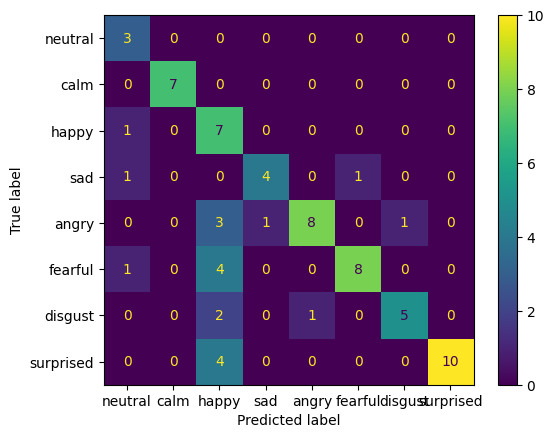

In [99]:
# move x axis labels to top? https://matplotlib.org/stable/gallery/ticks/tick_xlabel_top.html
cm_display = get_metrics(preds_tensor, labels_tensor)

## es_hubert

In [138]:
es_preds_tensor, es_labels_tensor = get_preds_labels(es_hubert, sarcasm_test_loader)

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

transplanted hubert!


100%|██████████| 35/35 [01:59<00:00,  3.41s/it]


accuracy=0.5652173913043478
precision=0.5666383701188455
recall=0.5659663865546218
f1=0.5643939393939394
support=None
[[18 17]
 [13 21]]


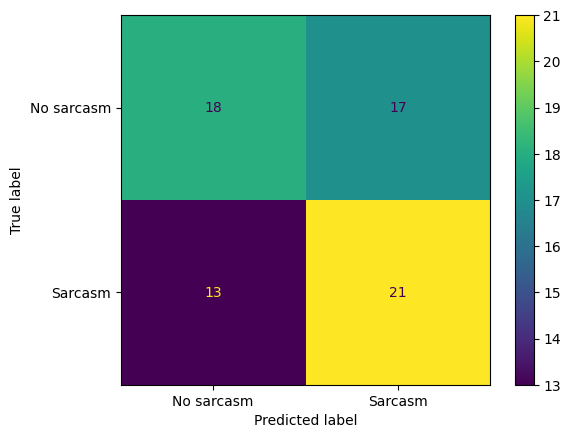

In [139]:
get_metrics(es_preds_tensor, es_labels_tensor, 'sarcasm')

## s_hubert

In [26]:
sarcasm_hubert_classifier_config = HubertClassifierConfig(num_classes=2)
sarcasm_hubert_classifier_model = HubertClassifierModel(sarcasm_hubert_classifier_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model ch

In [30]:
preds_tensor, labels_tensor = get_preds_labels(s_hubert, sarcasm_test_loader)

  0%|          | 0/18 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 502.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 53.06 MiB is free. Process 71979 has 14.69 GiB memory in use. Of the allocated memory 14.17 GiB is allocated by PyTorch, and 397.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

accuracy=0.5072463768115942
precision=0.2536231884057971
recall=0.5
f1=0.33653846153846156
support=None
[[35  0]
 [34  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


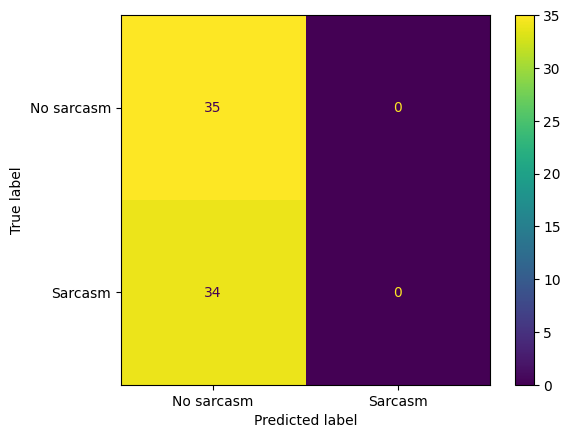

In [25]:
# move x axis labels to top? https://matplotlib.org/stable/gallery/ticks/tick_xlabel_top.html
cm_display = get_metrics(preds_tensor, labels_tensor, 'sarcasm')

## Plotting

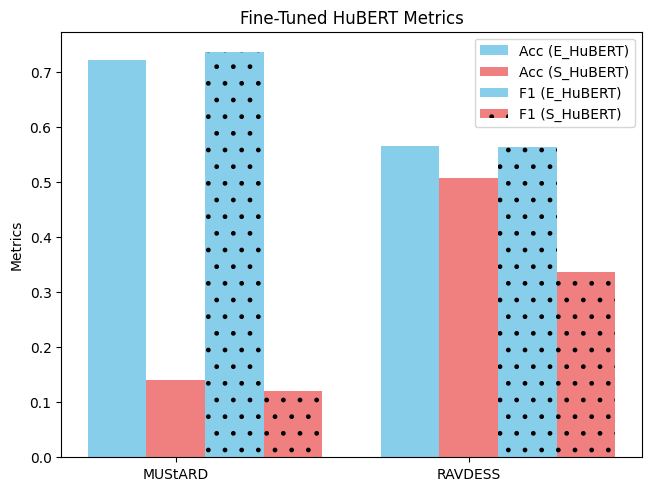

In [172]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ("MUStARD", "RAVDESS")
metrics = {
    'Acc (E_HuBERT)': (0.7222, 0.5652),
    'Acc (S_HuBERT)': (0.1407 ,0.5072),
    'F1 (E_HuBERT)': (0.7370, 0.5644),
    'F1 (S_HuBERT)': (0.1208, 0.3365),
}

x = np.arange(len(datasets))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

colors = {
    'Acc (E_HuBERT)': 'skyblue',
    'Acc (S_HuBERT)': 'lightcoral',
    'F1 (E_HuBERT)': 'skyblue',
    'F1 (S_HuBERT)': 'lightcoral',
}

hatches = {
    'Acc (E_HuBERT)': None,
    'Acc (S_HuBERT)': None,
    'F1 (E_HuBERT)': '.',
    'F1 (S_HuBERT)': '.',
}

for attribute, measurement in metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width=width, label=attribute,
                   color=colors[attribute], hatch=hatches[attribute])
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metrics')
ax.set_title('Fine-Tuned HuBERT Metrics')
ax.set_xticks(x + width, datasets)
ax.legend()

plt.show()

# Visualization

## Tutorial

In [145]:
df = px.data.iris()
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_id
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1


In [146]:
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width', color='species')
fig.show()

## General

In [20]:
from sklearn.decomposition import PCA
import plotly.express as px

In [21]:
def get_pca(model, loader):
    model = model.to(DEVICE)
    labels_tensor = torch.tensor([])
    pca_3_tensor = torch.tensor([])
    pca_3_fn = PCA(n_components=3)

    for batch in tqdm.tqdm(loader, total=len(loader)):
        input_values = batch['input_values'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        output = model(input_values=input_values, attention_mask=attention_mask)
        pooler_output = output['pooler_output'].cpu().detach().numpy()

        pca_out_3 = torch.from_numpy(pca_3_fn.fit_transform(pooler_output))

        pca_3_tensor = torch.concat((pca_3_tensor, pca_out_3), dim=0)
        labels_tensor = torch.concat((labels_tensor, batch['labels']), dim=0)
    # labels_tensor = labels_tensor.to(torch.int64)

    df_3 = pd.DataFrame({
        'labels': labels_tensor,
        'PC1': pca_3_tensor[:,0],
        'PC2': pca_3_tensor[:,1],
        'PC3': pca_3_tensor[:,2],
    })

    return df_3

## e_hubert

In [42]:
# # new dataframe
# e_df_3 = get_pca(e_hubert, emotion_train_loader)
# e_df_3.head()

100%|██████████| 36/36 [00:12<00:00,  2.96it/s]


,labels,PC1,PC2,PC3
0,3.0,4.467031,10.656122,-7.458345
1,0.0,2.583965,8.442933,4.199084
2,2.0,5.111879,-6.735325,3.098787
3,6.0,-4.547331,3.604392,7.867668
4,4.0,-10.960087,-2.167436,-2.147572


In [43]:
# e_df_3['labels'] = e_df_3['labels'].apply(lambda label: emotion_id2label[int(label)])
# e_df_3['labels'][0]

'sad'

In [55]:
# e_df_3.to_pickle('e_e.pkl')

In [83]:
# load dataframe
e_df_3 = pd.read_pickle('e_e.pkl')

In [112]:
e_color_seq = [
    'lightcoral',
    'darksalmon',
    'khaki',
    'palegreen',
    'darkseagreen',
    'lightskyblue',
    'pink',
    'plum',
]


e_colors = {v: c for v, c in zip(list(emotion_id2label.values()), e_color_seq)}
e_colors

{'neutral': 'lightcoral',
 'calm': 'darksalmon',
 'happy': 'khaki',
 'sad': 'palegreen',
 'angry': 'darkseagreen',
 'fearful': 'lightskyblue',
 'disgust': 'pink',
 'surprised': 'plum'}

In [88]:
# e_fig = px.scatter_3d(e_df_3, x='PC1', y='PC2', z='PC3', color='labels', color_discrete_map=e_colors)
# e_fig.show()

In [113]:
e_fig = px.scatter(
    e_df_3,
    x='PC1',
    y='PC2',
    color='labels',
    color_discrete_map=e_colors,
)
e_fig.update_traces(
    marker={'size': 15},
    textfont_size=50,
)
e_fig.update_layout(
    font=dict(size=20)
)
e_fig.show()

## es_hubert

In [61]:
# new dataframe
es_df_3 = get_pca(es_hubert, sarcasm_train_loader)
es_df_3.head()

100%|██████████| 35/35 [00:52<00:00,  1.50s/it]


,labels,PC1,PC2,PC3
0,0.0,2.021326,11.412317,0.289157
1,1.0,-0.086711,9.666472,-0.944212
2,0.0,-6.565923,-5.020369,1.271100
3,1.0,8.739140,-5.201111,3.815779
4,0.0,-9.796676,0.385798,11.863627


In [62]:
es_df_3['labels'] = es_df_3['labels'].apply(lambda label: 'sarcasm' if label == 1 else 'no sarcasm')
es_df_3.iloc[0]

labels    no sarcasm
PC1         2.021326
PC2        11.412317
PC3         0.289157
Name: 0, dtype: object

In [63]:
es_df_3.to_pickle('e_s.pkl')

In [64]:
# load dataframe
es_df_3 = pd.read_pickle('e_s.pkl')

In [65]:
fig = px.scatter_3d(es_df_3, x='PC1', y='PC2', z='PC3', color='labels')
fig.show()

In [67]:
fig = px.scatter(es_df_3, x='PC1', y='PC2', color='labels')
fig.show()

## s_hubert

In [22]:
# new dataframe
s_df = get_pca(s_hubert, sarcasm_train_loader)
s_df.head()

100%|██████████| 138/138 [00:52<00:00,  2.62it/s]


,labels,PC1,PC2,PC3
0,0.0,0.001123,-0.000059,0.000035
1,1.0,-0.000460,-0.000169,-0.000073
2,0.0,-0.000694,0.000025,0.000102
3,1.0,0.000031,0.000203,-0.000064
4,0.0,-0.001227,-0.000134,-0.000064


In [23]:
s_df['labels'] = s_df['labels'].apply(lambda label: 'sarcasm' if label == 1 else 'no sarcasm')
s_df.iloc[0]

labels    no sarcasm
PC1         0.001123
PC2        -0.000059
PC3         0.000035
Name: 0, dtype: object

In [24]:
s_df.to_pickle('s_s.pkl')

In [25]:
fig = px.scatter_3d(s_df, x='PC1', y='PC2', z='PC3', color='labels')
fig.show()

In [26]:
fig = px.scatter(s_df, x='PC1', y='PC2', color='labels')
fig.show()

# Sarcasm closest emotion

In [27]:
from collections import defaultdict

In [28]:
e_e_df = pd.read_pickle('e_e.pkl')
e_s_df = pd.read_pickle('e_s.pkl')

In [36]:
e_e_df.head()

,labels,PC1,PC2,PC3
0,sad,4.467031,10.656122,-7.458345
1,neutral,2.583965,8.442933,4.199084
2,happy,5.111879,-6.735325,3.098787
3,disgust,-4.547331,3.604392,7.867668
4,angry,-10.960087,-2.167436,-2.147572


In [58]:
pc3_tensor = torch.tensor((e_e_df['PC1'], e_e_df['PC2'], e_e_df['PC3'])).T
print(pc3_tensor.shape)

pc2_tensor = torch.tensor((e_e_df['PC1'], e_e_df['PC2'])).T
print(pc2_tensor.shape)

torch.Size([576, 3])
torch.Size([576, 2])


In [65]:
cos = nn.CosineSimilarity(dim=1)

a = torch.randn(3)
d = cos(a, pc3_tensor)
ix = torch.argmax(d)
print(e_e_df.iloc[ix.item()]['labels'])

disgust


In [116]:
sarcasm_count = defaultdict(int)
no_sarcasm_count = defaultdict(int)
cos = nn.CosineSimilarity(dim=1)

fearful_ixs = []
happy_ixs = []

for ix, row in e_s_df.iterrows():
    v = torch.tensor([row['PC1'], row['PC2'], row['PC3']])
    d = cos(v, pc3_tensor)
    emotion_ix = torch.argmax(d)
    emotion = e_e_df.iloc[emotion_ix.item()]['labels']
    sarcasm = row['labels']

    if emotion == 'fearful' and sarcasm == 'sarcasm':
        fearful_ixs.append(ix)
    elif emotion == 'happy' and sarcasm == 'no sarcasm':
        happy_ixs.append(ix)

    if sarcasm == 'sarcasm':
        sarcasm_count[emotion] += 1
    elif sarcasm == 'no sarcasm':
        no_sarcasm_count[emotion] += 1

print('sarcasm:')
print(json.dumps(sarcasm_count, indent=2))
for t in sorted(sarcasm_count.items(), key=lambda t: t[1], reverse=True):
    print(t)

print()
print('no sarcasm')
print(json.dumps(no_sarcasm_count, indent=2))
for t in sorted(no_sarcasm_count.items(), key=lambda t: t[1], reverse=True):
    print(t)

sarcasm:
{
  "sad": 36,
  "disgust": 48,
  "fearful": 61,
  "surprised": 23,
  "angry": 34,
  "happy": 28,
  "calm": 29,
  "neutral": 20
}
('fearful', 61)
('disgust', 48)
('sad', 36)
('angry', 34)
('calm', 29)
('happy', 28)
('surprised', 23)
('neutral', 20)

no sarcasm
{
  "disgust": 41,
  "fearful": 52,
  "neutral": 19,
  "surprised": 21,
  "sad": 34,
  "happy": 36,
  "angry": 40,
  "calm": 30
}
('fearful', 52)
('disgust', 41)
('angry', 40)
('happy', 36)
('sad', 34)
('calm', 30)
('surprised', 21)
('neutral', 19)


In [120]:
fig = px.scatter(e_s_df.iloc[fearful_ixs + happy_ixs], x='PC1', y='PC2', color='labels')
fig.show()

In [121]:
add_df = e_s_df.iloc[fearful_ixs + happy_ixs]
add_df.head()

,labels,PC1,PC2,PC3
7,sarcasm,12.219895,0.136894,-0.366630
10,sarcasm,-5.817092,-3.650659,-2.913128
21,sarcasm,9.681768,-1.759505,-4.033143
24,sarcasm,4.599759,-6.934952,-1.414837
26,sarcasm,5.235363,-6.633186,-1.439811


In [130]:
combine_df = pd.concat((e_e_df, add_df))
print(e_e_df.shape)
print(add_df.shape)
print(combine_df.shape)
combine_df.head(10)

(576, 4)
(97, 4)
(673, 4)


,labels,PC1,PC2,PC3
0,sad,4.467031,10.656122,-7.458345
1,neutral,2.583965,8.442933,4.199084
2,happy,5.111879,-6.735325,3.098787
3,disgust,-4.547331,3.604392,7.867668
4,angry,-10.960087,-2.167436,-2.147572
5,calm,2.947896,11.734603,9.959467
6,happy,4.929134,-6.791537,2.979988
7,angry,-11.196064,-1.882002,-2.061288
8,angry,-11.240504,-1.777946,-2.089428
9,angry,-11.125914,-1.999918,-2.076632


In [143]:
# color
combine_color_seq = [
    'khaki',
    'darksalmon',
    'lightcoral',
    'palegreen',
    'darkseagreen',
    'lightskyblue',
    'pink',
    'plum',
]
combine_colors = {v: c for v, c in zip(list(emotion_id2label.values()), combine_color_seq)}
combine_colors['sarcasm'] = 'blue'
combine_colors['no sarcasm'] = 'red'

# symbol
combine_symbols = {v: 'circle' for v in emotion_id2label.values()}
combine_symbols['sarcasm'] = 'diamond'
combine_symbols['no sarcasm'] = 'diamond'
print(json.dumps(combine_symbols, indent=2))

# figure
combine_fig = px.scatter(
    combine_df,
    x='PC1',
    y='PC2',
    color='labels',
    color_discrete_map=combine_colors,
    symbol='labels',
    symbol_map=combine_symbols,
)
combine_fig.update_traces(
    marker={'size': 15},
    textfont_size=50,
)
combine_fig.update_layout(
    font=dict(size=20)
)
combine_fig.show()

{
  "neutral": "circle",
  "calm": "circle",
  "happy": "circle",
  "sad": "circle",
  "angry": "circle",
  "fearful": "circle",
  "disgust": "circle",
  "surprised": "circle",
  "sarcasm": "diamond",
  "no sarcasm": "diamond"
}
